# iCORE XAI Workshop: simple tabular example


**Model**

[Census Income Dataset](https://archive.ics.uci.edu/ml/datasets/adult) - "Predict whether income exceeds $50K/yr based on census data."

**References**

- [Census income classification with Keras](https://shap.readthedocs.io/en/latest/example_notebooks/tabular_examples/neural_networks/Census%20income%20classification%20with%20Keras.html)

## Setup 

In [1]:
from google.colab.output import eval_js

In [2]:
eval_js('google.colab.output.setIframeHeight("200")')  # Shrink the output cell height
!pip install eli5

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 216 kB 4.3 MB/s 
     |████████████████████████████████| 133 kB 50.3 MB/s 
  Created wheel for eli5: filename=eli5-0.13.0-py2.py3-none-any.whl size=107748 sha256=d8f7fa0a2d7fedccb4a966b082d89ff98af3f41d4e185d50a1cbfba57cf664a8
  Stored in directory: /root/.cache/pip/wheels/cc/3c/96/3ead31a8e6c20fc0f1a707fde2e05d49a80b1b4b30096573be
Successfully built eli5
  Attempting uninstall: jinja2
    Found existing installation: Jinja2 2.11.3
    Uninstalling Jinja2-2.11.3:
      Successfully uninstalled Jinja2-2.11.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
notebook 5.7.16 requires jinja2<=3.0.0, but you have jinja2 3.1.2 which is incompatible.
flask 1.1.4 requires Jinja2<3.0,>=2.10.1, but you have jinja2 3.1.2 which is incompa

In [3]:
eval_js('google.colab.output.setIframeHeight("200")')  # Shrink the output cell height
!pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 569 kB 4.3 MB/s 


In [4]:
eval_js('google.colab.output.setIframeHeight("200")')  # Shrink the output cell height
!pip install lime

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 275 kB 4.2 MB/s 
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283858 sha256=2caa8c398d04034adbf0ab6ebbe2d8f94ffdd2c4f8e23fb82bcd5bf6af0a128a
  Stored in directory: /root/.cache/pip/wheels/ca/cb/e5/ac701e12d365a08917bf4c6171c0961bc880a8181359c66aa7
Successfully built lime


In [5]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from tqdm import tqdm

# Machine learning
from sklearn.model_selection import train_test_split
import sklearn

# Model metrics
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# XAI libraries
import shap
import lime
from lime import lime_tabular
from eli5.sklearn import PermutationImportance
import eli5

## Initialize model

### Load dataset

In [6]:
X,y = shap.datasets.adult()
X_display,y_display = shap.datasets.adult(display=True)

# normalize data (this is important for model convergence)
dtypes = list(zip(X.dtypes.index, map(str, X.dtypes)))
for k,dtype in dtypes:
    if dtype == "float32":
        X[k] -= X[k].mean()
        X[k] /= X[k].std()

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=7)

### Initialize & train model

In [7]:
knn = sklearn.neighbors.KNeighborsClassifier()
knn.fit(X_train, y_train)

KNeighborsClassifier()

### Evaluate performance

In [8]:
# Make predictions
P_train = knn.predict(X_train)
P_valid = knn.predict(X_valid)

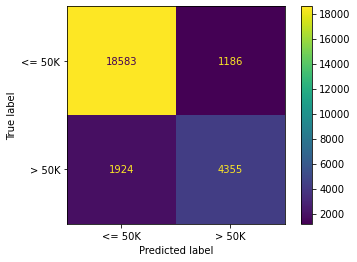

In [9]:
# Training data metrics
disp = ConfusionMatrixDisplay(confusion_matrix(y_train, P_train), display_labels=["<= 50K", "> 50K"])
disp.plot()

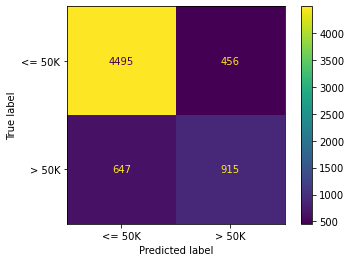

In [10]:
# Training data metrics
disp = ConfusionMatrixDisplay(confusion_matrix(y_valid, P_valid), display_labels=["<= 50K", "> 50K"])
disp.plot()

## XAI demonstration

### Application of multiple XAI methods

**Method: Permutation Feature Importance**

- A feature importance method

In [11]:
# Run XAI method
perm = PermutationImportance(knn, random_state=1).fit(X_valid,y_valid)

In [12]:
# View results
feature_names = np.array(X_valid.columns.tolist())
pfi_values = perm.feature_importances_

for i, name in enumerate(feature_names):
  print("{}: \t\t {:.3f}".format(name, pfi_values[i]))

Age: 		 0.013
Workclass: 		 0.011
Education-Num: 		 0.029
Marital Status: 		 0.024
Occupation: 		 0.024
Relationship: 		 0.024
Race: 		 0.000
Sex: 		 0.000
Capital Gain: 		 0.017
Capital Loss: 		 0.003
Hours per week: 		 0.007
Country: 		 0.001


In [13]:
# Or as a nicer table
dfPFI = pd.DataFrame(
    {
        "Feature" : feature_names,
        "PFI" : pfi_values,
    }
)

dfPFI

,Feature,PFI
0,Age,0.012805
1,Workclass,0.011331
2,Education-Num,0.028773
3,Marital Status,0.023706
4,Occupation,0.024228
5,Relationship,0.024136
6,Race,0.000307
7,Sex,0.000338
8,Capital Gain,0.016521
9,Capital Loss,0.003163


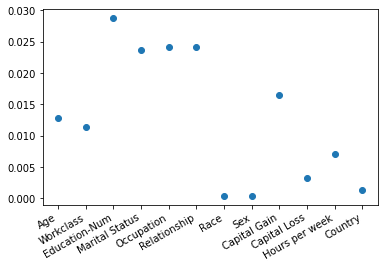

In [14]:
# Plot PFI values
fig, ax = plt.subplots()
ax.scatter(feature_names, pfi_values)
fig.autofmt_xdate()

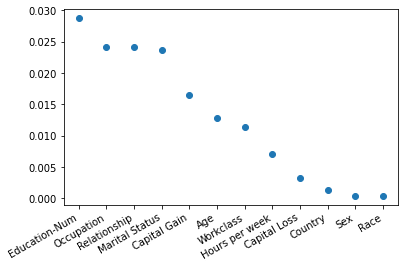

In [15]:
# Plot ordered PFI values
fig, ax = plt.subplots()
pfi_idx = np.argsort(pfi_values)[::-1]
ax.scatter(feature_names[pfi_idx], pfi_values[pfi_idx])
fig.autofmt_xdate()

In [16]:
# Take advantage of library visualizations
eli5.show_weights(perm, feature_names = X_valid.columns.tolist())

Weight,Feature
0.0288 ± 0.0054,Education-Num
0.0242 ± 0.0038,Occupation
0.0241 ± 0.0084,Relationship
0.0237 ± 0.0057,Marital Status
0.0165 ± 0.0033,Capital Gain
0.0128 ± 0.0034,Age
0.0113 ± 0.0033,Workclass
0.0071 ± 0.0047,Hours per week
0.0032 ± 0.0011,Capital Loss
0.0013 ± 0.0012,Country


**Method: SHAP**

In [17]:
f = lambda x: knn.predict_proba(x)[:,1]
med = X_train.median().values.reshape((1,X_train.shape[1]))

In [18]:
eval_js('google.colab.output.setIframeHeight("500")')  # Shrink the output cell height
explainer = shap.Explainer(f, med)
shap_values = explainer(X_valid.iloc[0:100,:])

X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
X does not have valid feature names, but KNeighborsClassifier was fitted with fe

**Explain single predictions**

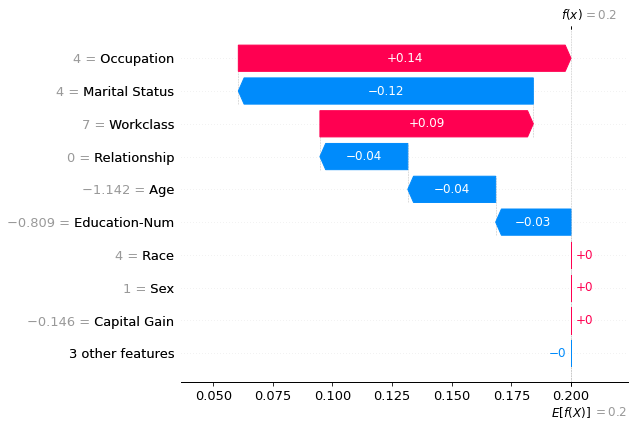

In [19]:
# SHAP waterfall plot
shap.plots.waterfall(shap_values[3])

**Explain set of predictions**

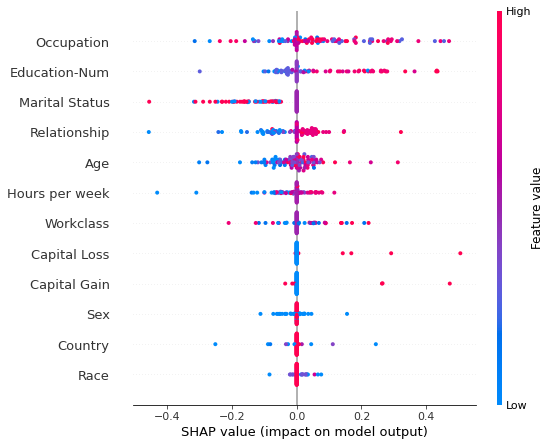

In [20]:
# Summary plot
shap.summary_plot(shap_values, X_valid.iloc[0:100,:])

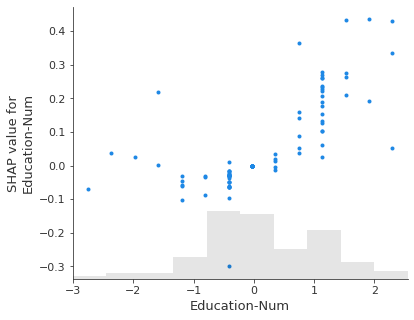

In [21]:
# Dependence scatter plot
shap.plots.scatter(shap_values[:,"Education-Num"])

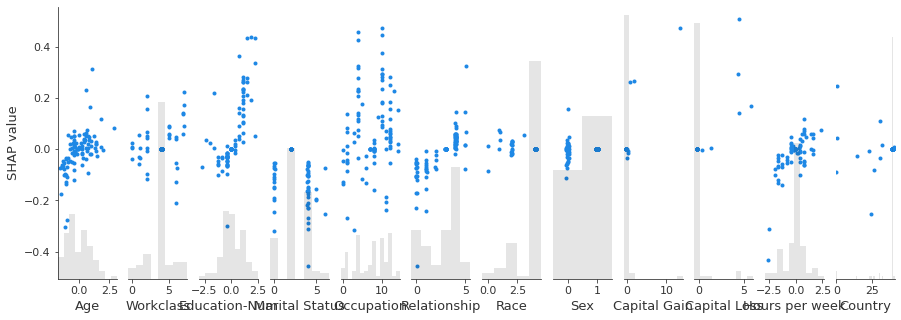

In [22]:
# All of them
shap.plots.scatter(shap_values[:, :])

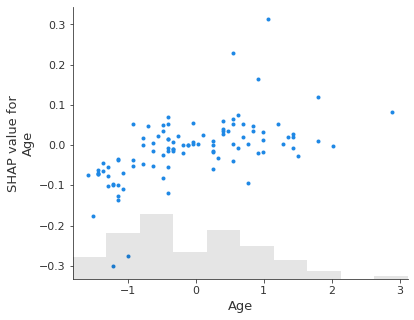

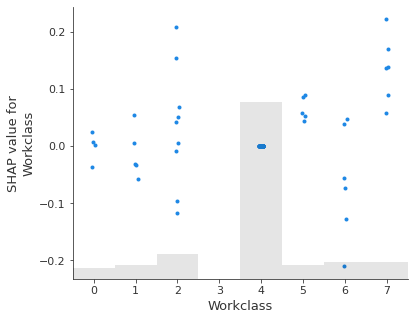

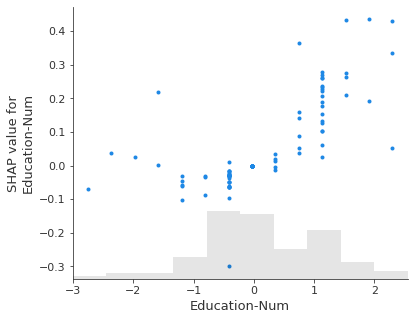

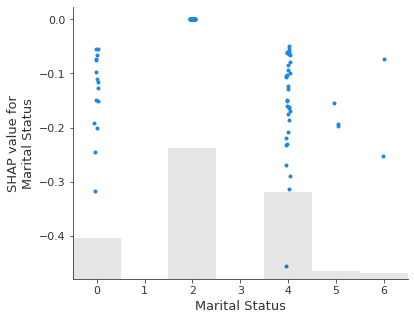

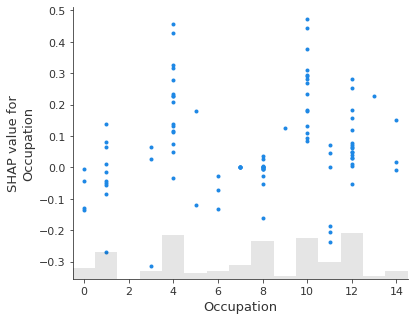

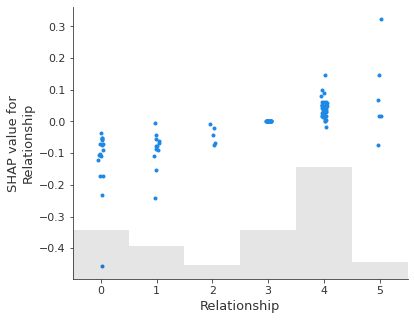

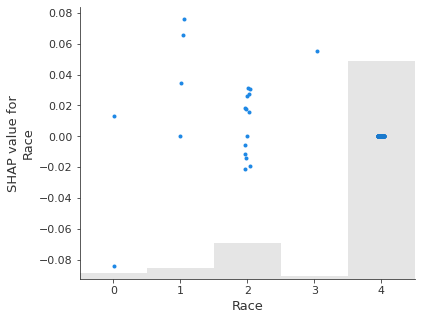

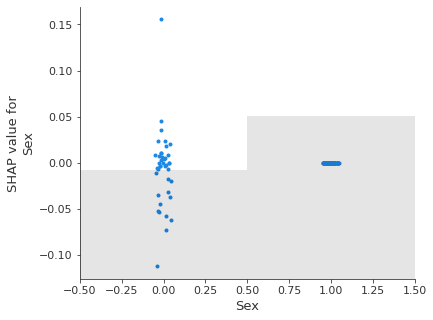

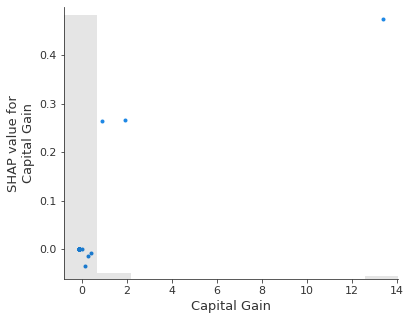

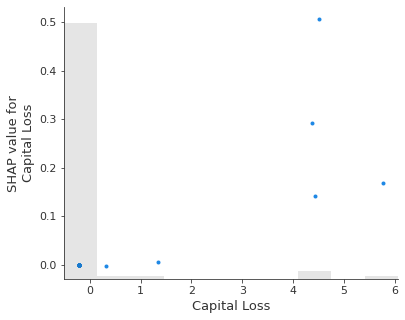

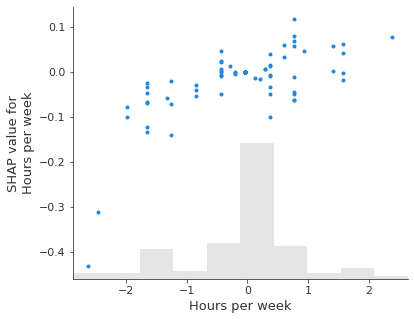

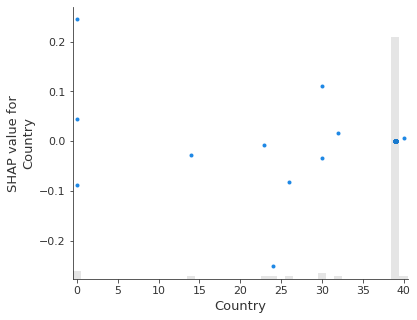

In [23]:
# Can we make it prettier?

features = X_valid.columns.tolist()
n_features = len(features)

for i, feature in enumerate(features):
  shap.plots.scatter(shap_values[:, feature])
  print("\n\n")

# Note: I wanted to use 'ax=ax[i]' to format my own subplots, but SHAP API seems broken in this respect. 
# Which is far from the only SHAP bug I and others have encountered

**Method: LIME**

In [24]:
explainer = lime_tabular.LimeTabularExplainer(X_valid.values, feature_names=feature_names)

In [27]:
# Explain an instance
instance_idx = 3
exp = explainer.explain_instance(X_valid.values[instance_idx], knn.predict_proba, num_features=n_features, top_labels=1)

X does not have valid feature names, but KNeighborsClassifier was fitted with feature names


In [28]:
# Show explanation
exp.show_in_notebook(show_table=True, show_all=False)